In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.compare import compare_survival
from statsmodels.stats.multitest import multipletests

from tqdm.notebook import trange
import joblib

In [2]:
%matplotlib inline
%load_ext watermark

In [3]:
# set a fixed random state for reproduceability random state from random.org
import random
random.seed(0x39d6462a)
#np.random.seed(random.randint(0, 0x1<<31))
cgbsa_rand_seed = random.getrandbits(30)
cgbsa_tts_rand_seed = random.getrandbits(30)
bootstrap_rand_seed = random.getrandbits(30)

In [4]:
with open('../data/gene-names.yaml') as in_fd:
    name_map = yaml.load(in_fd, yaml.FullLoader)
    
name_map.update({
    'sample' : 'sample',
    'accession' : 'accession',
    'age-at-diag' : 'age-at-diag',
    'death' : 'death',
    'over-all-survival' : 'over-all-survival',
    'event-free-survival' : 'event-free-survival'
})
expression_data = pd.read_csv('../data/GSE58812.csv.xz')
expression_data['death'] = expression_data['death'].astype(bool)

expression_data.rename(
    inplace=True,
    columns={
        k : name_map.get(k, k)
            for k in expression_data.columns
    }
)
del name_map
expression_data.head()

,sample,accession,age-at-diag,death,over-all-survival,event-free-survival,DDR1 /// MIR4640,RFC2,HSPA6,PAX8,...,Unnamed: 54671,Unnamed: 54672,Unnamed: 54673,Unnamed: 54674,Unnamed: 54675,Unnamed: 54676,Unnamed: 54677,Unnamed: 54678,Unnamed: 54679,Unnamed: 54680
0,GP_001,GSM1419942,72.79124,True,1520,1184,3250.234,581.6899,548.0052,78.18101,...,5.013100,5.013100,5.013100,5.013100,5.013100,5.013100,5.013100,5.013100,5.013100,5.013100
1,GP_002,GSM1419943,66.26421,True,1281,984,6937.957,491.9329,586.6774,16.27092,...,17.526300,17.526300,17.526300,17.526300,17.526300,17.526300,17.526300,17.526300,17.526300,17.526300
2,GP_003,GSM1419944,67.75633,True,1066,877,1890.808,571.5949,1017.9750,51.52081,...,2.841974,2.841974,2.841974,2.841974,2.841974,2.841974,2.841974,2.841974,2.841974,2.841974
3,GP_004,GSM1419945,49.54963,True,1050,905,1858.513,1128.9250,1194.4770,47.17675,...,4.557837,4.557837,4.557837,4.557837,4.557837,4.557837,4.557837,4.557837,4.557837,4.557837
4,GP_005,GSM1419946,84.63245,True,422,340,2876.979,734.7979,1153.9280,21.07965,...,2.660254,2.660254,2.660254,2.660254,2.660254,2.660254,2.660254,2.660254,2.660254,2.660254


In [5]:
clf = joblib.load('../data/classifier.joblib')
feature_names = clf.feature_names_in_
missing_feature_names = [f for f in feature_names if f not in expression_data.columns]
print('missing genes', *missing_feature_names)

missing genes MIR3667HG CCL4L1 GPR179 BHLHE22-AS1 XRCC6P5 MRPL42P5 Prss45 Smc1b SSPOP TUBB8 TYW1B WEE2


In [6]:
metadata = ['age-at-diag','death','over-all-survival','event-free-survival']
genes = [f for f in feature_names if f in expression_data.columns]
print(expression_data['death'].value_counts())
expression_data[metadata + genes].describe()

False    78
True     29
Name: death, dtype: int64


,age-at-diag,over-all-survival,event-free-survival,ADAM19,ADH5,BTNL8,DHRS4-AS1,PRR34,PLGRKT,CALHM1,...,SERPINC1,SULT1E1,SYCP2L,DYNLT5,TMEM177,TTPA,UCN2,ZC3H8,ZFP64,ZNF629
count,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,...,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000
mean,56.965387,2202.635514,2116.028037,53.974226,1637.718083,11.064447,1069.047099,18.536976,1188.539203,76.532034,...,11.785016,96.136115,91.340338,40.213246,65.858448,31.648316,42.672133,297.651972,32.451178,506.086801
std,12.800894,1251.161607,1322.561547,19.974338,765.250231,12.776294,470.954495,19.072184,595.772200,25.245209,...,14.976069,376.600607,124.853787,22.922093,30.578564,18.776435,44.623459,117.312229,17.263443,213.621607
min,28.481860,20.000000,20.000000,8.272188,420.292400,1.252837,444.769500,3.254660,219.618000,16.195060,...,1.213345,0.825625,4.157613,3.605764,2.396563,1.507440,3.901340,88.472710,1.174422,219.282200
25%,49.348395,1271.500000,1000.500000,41.605335,1130.487000,3.446560,772.356800,8.014554,745.063200,58.323575,...,3.802615,3.681759,28.714890,27.761610,46.189275,19.607240,10.309390,209.307650,19.845430,388.229550
50%,57.341550,2032.000000,2025.000000,51.399940,1502.371000,6.318987,973.399300,12.462480,1163.675000,73.619260,...,6.137250,14.254740,47.648370,37.524590,66.339280,31.145610,28.869420,278.956700,33.533410,453.022300
75%,66.338125,2996.000000,2996.000000,66.832610,1944.885000,11.233220,1246.095500,19.985000,1461.924000,92.237105,...,11.419785,34.725590,84.712365,49.554685,85.921060,42.160445,54.237420,359.226300,42.355455,577.566000
max,84.632450,5150.000000,5150.000000,103.696800,4076.937000,84.160170,3374.366000,108.972200,3354.006000,144.502400,...,94.411020,3189.358000,697.521900,138.154900,164.662900,89.147670,253.654500,743.040900,95.001730,1957.042000


In [7]:
survival_data = pd.DataFrame.from_records(
    [compare_survival(
        expression_data[['death', 'over-all-survival']].to_records(index=False),
        expression_data[gene]
    )
     for gene in genes],
    columns=['chi-square','p-value'],
    index=genes
)
survival_data.sort_values('p-value', inplace=True)
fdr_correction = multipletests(survival_data['p-value'], method='fdr_tsbky')
survival_data['FDR'] = fdr_correction[1]
survival_data['reject'] = fdr_correction[0]
survival_data

LinAlgError: Singular matrix

In [11]:
X,y = (expression_data[['age-at-diag'] + genes],
    expression_data[['death', 'over-all-survival']].to_records(index=False))
est_cph = make_pipeline(
    StandardScaler(),
    CoxPHSurvivalAnalysis(
        ties='efron',
        alpha=0
    )
)
est_cph.fit(X, y)
print(est_cph.score(X,y))
pd.DataFrame(
    est_cph.named_steps.coxphsurvivalanalysis.coef_,
    index=X.columns
).sort_values(0, ascending=False)

/home/seth/miniconda3/envs/condaenv/lib/python3.9/site-packages/sksurv/linear_model/coxph.py:174: RuntimeWarning: overflow encountered in exp
  risk_set += numpy.exp(xw[k])
/home/seth/miniconda3/envs/condaenv/lib/python3.9/site-packages/sksurv/linear_model/coxph.py:171: RuntimeWarning: overflow encountered in exp
  risk_set2 += numpy.exp(xw[k])


0.976228847703465


/home/seth/miniconda3/envs/condaenv/lib/python3.9/site-packages/sklearn/pipeline.py:394: ConvergenceWarning: Optimization did not converge: Maximum number of iterations has been exceeded.
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


,0
PIF1,17.657934
RPS26P11,17.297181
HTR1B,16.917447
PAX6,14.149488
KLK10,12.967535
ELAPOR2,11.351588
CAT,10.711734
age-at-diag,9.648298
BTNL8,9.627896
LIMS3,9.062500


In [10]:
rand_state = np.random.RandomState(seed=bootstrap_rand_seed)
test_clf = make_pipeline(
    StandardScaler(),
    CoxPHSurvivalAnalysis(
        ties='efron',
        alpha=0
    )
)

X,y = (expression_data[['age-at-diag'] + genes],
    expression_data[['death', 'over-all-survival']].to_records(index=False))

replicates = []
for _ in trange(500, leave=False):
    feature_X_train, feature_X_test, y_train, y_test = train_test_split(
        X, y,
        random_state=rand_state
    )

    test_clf.fit(feature_X_train, y_train)
    replicates.append(test_clf.named_steps.coxphsurvivalanalysis.coef_)

  0%|          | 0/500 [00:00<?, ?it/s]

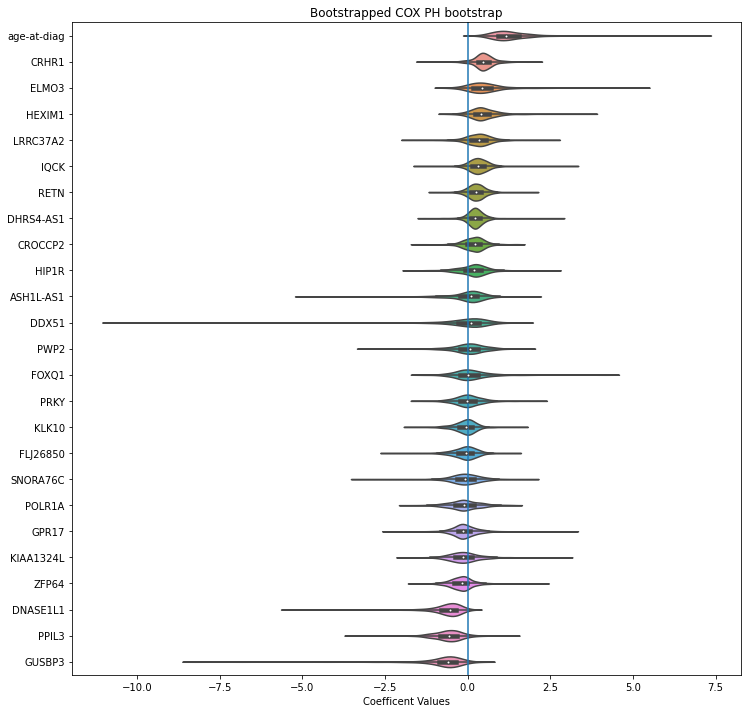

In [11]:
coef_data = pd.DataFrame(
  np.row_stack(replicates),
  columns=X.columns
)

plt.figure(figsize=(12,12))
plt.title('Bootstrapped COX PH bootstrap')
plt.xlabel('Coefficent Values')
sns.violinplot(
    data=coef_data,
    orient='h',
    order=list(coef_data.median(axis=0).sort_values(ascending=False).index)
)
plt.axvline(0)
#plt.savefig('../figures/bootstrap-shap-importance.eps')
plt.show()

In [11]:
%watermark \
--python \
--packages pandas,sklearn,sksurv,matplotlib,seaborn,statsmodels \
--date --updated

Last updated: 2022-03-09

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 7.31.1

pandas     : 1.3.5
sklearn    : 1.0.2
sksurv     : 0.0.0
matplotlib : 3.5.0
seaborn    : 0.11.2
statsmodels: 0.13.2

